### Analysis of PTZ protocol for susceptibility to epileptic seizures

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import fisher_exact
from sklearn.utils import resample
from scipy.stats import binom_test

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.6, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
ptz_raw = pd.read_csv('/Users/labc02/Documents/PDCB_data/MK-project/PTZ_protocol.csv')

In [3]:
ptz_raw.columns

Index(['ID', 'Sex', 'Genotype', 'Tx', 'Weight', '0 mg/kg', '20 mg/kg',
       '40 mg/kg', '60 mg/kg', '80 mg/kg', 'Fatalities', 'CoD'],
      dtype='object')

In [4]:
rename_dic = {}
for col in range(5, 10):
    name = ptz_raw.columns[col]
    new_name = name.split()[0]
    rename_dic[name] = int(new_name)

In [5]:
ptz_raw.rename(columns= rename_dic, inplace = True)

In [6]:
ptz_raw.columns

Index(['ID', 'Sex', 'Genotype', 'Tx', 'Weight', 0, 20, 40, 60, 80,
       'Fatalities', 'CoD'],
      dtype='object')

In [7]:
ptz_raw.groupby(['Genotype', 'Tx'])['ID'].count()

Genotype  Tx    
KO        MK-0.5    12
          Pl        12
WT        MK-0.5    12
          MK-1      10
          Pl        12
Name: ID, dtype: int64

In [8]:
ptz_scale = ptz_raw.drop(['Fatalities', 'CoD'], axis = 1) # Selecting columns with seizure severity

In [9]:
ptz_mort = ptz_raw.drop(ptz_raw.columns[[5, 6, 7, 8, 9]], axis = 1) # Selecting columns of fatalilties

In [10]:
ptz_scale = pd.melt(ptz_scale, id_vars=['ID', 'Sex', 'Genotype', 'Tx', 'Weight'], value_vars = [0, 20, 40, 60, 80], var_name = 'Dose', value_name = 'Severity')


In [13]:
ptz_scale.head()

,ID,Sex,Genotype,Tx,Weight,Dose,Severity
0,WT_8.4.9,Female,WT,Pl,22.85,0,0
1,KO_8.5.1,Female,KO,MK-0.5,27.05,0,0
2,KO_8.5.2,Female,KO,MK-0.5,25.12,0,0
3,WT_6.6.5,Female,WT,Pl,28.36,0,0
4,WT_6.6.1,Female,WT,MK-0.5,26.43,0,0


In [14]:
ptz_mort_p = ptz_mort.groupby(['Genotype', 'Tx'])['Fatalities'].sum()/ptz_mort.groupby(['Genotype', 'Tx'])['Fatalities'].count()


In [23]:
mort_df = ptz_mort_p.reset_index()

In [25]:
mort_df['Group'] = mort_df['Genotype']+'_'+ mort_df['Tx']

In [27]:
mort_df.head()

,Genotype,Tx,Fatalities,Group
0,KO,MK-0.5,0.250000,KO_MK-0.5
1,KO,Pl,0.250000,KO_Pl
2,WT,MK-0.5,0.583333,WT_MK-0.5
3,WT,MK-1,0.200000,WT_MK-1
4,WT,Pl,0.166667,WT_Pl


Text(0.455, 0.95, '**')

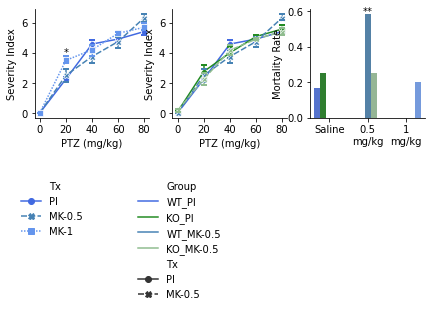

In [140]:
ptz_fig = plt.figure(figsize = (7, 2))
ax_1 = plt.subplot(131)
sns.lineplot(data = ptz_scale[ptz_scale['Genotype'] == 'WT'], x = 'Dose', y= 'Severity', hue='Tx', style = 'Tx', markers =True, palette= ['royalblue', 'steelblue', 'cornflowerblue'], err_style = 'bars', ci = 68, err_kws={'capsize': 3, 'capthick':2}, legend='brief', ax = ax_1)
sns.despine()
ax_1.set_ylabel('Severity Index')
ax_1.set_xlabel('PTZ (mg/kg)')
ax_1.set_xticks([0, 20, 40, 60, 80])
ax_1.annotate('*', xy=(.25, .57), xytext=(.25,.575), xycoords='axes fraction', fontsize=10)
ax_1.legend(ncol = 1, frameon = False, bbox_to_anchor=(.5, -.5))
ax_2 = plt.subplot(132)
sns.lineplot(data = ptz_scale[ptz_scale['Tx']!='MK-1'], x = 'Dose', y= 'Severity', hue = 'Group', style = 'Tx', markers =True, hue_order=['WT_Pl', 'KO_Pl', 'WT_MK-0.5', 'KO_MK-0.5'], palette= ['royalblue', 'forestgreen', 'steelblue', 'darkseagreen'], err_style = 'bars', ci = 68, err_kws={'capsize': 3, 'capthick':2}, legend='brief', ax = ax_2)
sns.despine()
ax_2.set_ylabel('Severity Index')
ax_2.set_xlabel('PTZ (mg/kg)')
ax_2.set_xticks([0, 20, 40, 60, 80])
ax_2.legend(ncol = 1, frameon = False, bbox_to_anchor=(.5, -.5))
ax_3 = plt.subplot(133)
sns.barplot(data = mort_df, x = 'Tx', y = 'Fatalities', hue = 'Group', order = ['Pl', 'MK-0.5', 'MK-1'], hue_order=['WT_Pl', 'KO_Pl', 'WT_MK-0.5', 'KO_MK-0.5', 'WT_MK-1'], palette= ['royalblue', 'forestgreen', 'steelblue', 'darkseagreen', 'cornflowerblue'], dodge=True, ax = ax_3)
sns.despine()
ax_3.set_xticklabels(['Saline', '0.5\nmg/kg', '1\nmg/kg'])
ax_3.set_xlabel('')
ax_3.set_ylabel('Mortality Rate')
ax_3.legend().remove()
ax_3.annotate('**', xy=(.455, 1), xytext=(.455,.95), xycoords='axes fraction', fontsize=10)
#ax_3.annotate('12', xy =(.05, .3), xytext = (.05, .3), xycoords = 'axes fraction')
#ax_3.annotate('12', xy =(.18, .3), xytext = (.18, .3), xycoords = 'axes fraction')
#ax_3.annotate('10', xy =(.38, .3), xytext = (.38, .3), xycoords = 'axes fraction')
#ax_3.annotate('12', xy =(.52, .98), xytext = (.52, .98), xycoords = 'axes fraction')
#ax_3.annotate('10', xy =(.84, .3), xytext = (.84, .3), xycoords = 'axes fraction')
#plt.tight_layout()


In [141]:
ptz_fig.savefig('/Users/labc02/Documents/PDCB_data/MK-project/Figures/PTZ_fig.svg')

### Stats

#### Tx effect on WT group

In [33]:
ptz_scale['Group'] = ptz_scale['Genotype'] + '_' + ptz_scale['Tx']

In [35]:
pg.mixed_anova(data = ptz_scale[ptz_scale['Genotype'] == 'WT'], dv = 'Severity', within = 'Dose', between = 'Tx', subject = 'ID')

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Tx,3.285256,2,29,1.642628,1.180921,3.213278e-01,NaN,0.075309,NaN,NaN,NaN,NaN
1,Dose,670.740625,4,116,167.685156,258.076735,9.563772e-57,4.351380e-42,0.898982,0.739964,False,0.434908,0.003637
2,Interaction,16.388466,8,116,2.048558,3.152844,2.887760e-03,NaN,0.178603,NaN,NaN,NaN,NaN


In [70]:
pg.pairwise_ttests(data = ptz_scale[ptz_scale['Genotype'] == 'WT'], dv = 'Severity', within='Dose', between = 'Tx', subject='ID', padjust='holm')


/opt/miniconda3/envs/databs/lib/python3.8/site-packages/pingouin/effsize.py:728: RuntimeWarning: invalid value encountered in double_scalars
  d = (x.mean() - y.mean()) / poolsd


,Contrast,Dose,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Dose,-,0,20,True,True,-13.502538,33.000000,two-sided,5.406746e-15,3.784722e-14,holm,1.206e+12,-3.237491
1,Dose,-,0,40,True,True,-20.418737,33.000000,two-sided,2.714117e-20,2.171293e-19,holm,1.525e+17,-4.895781
2,Dose,-,0,60,True,True,-34.739068,33.000000,two-sided,1.445689e-27,1.301120e-26,holm,1.643e+24,-8.329354
3,Dose,-,0,80,True,True,-39.059280,33.000000,two-sided,3.303730e-29,3.303730e-28,holm,6.376e+25,-9.365207
4,Dose,-,20,40,True,True,-6.441971,33.000000,two-sided,2.642769e-07,7.928306e-07,holm,6.011e+04,-1.231365
5,Dose,-,20,60,True,True,-10.457853,33.000000,two-sided,5.214656e-12,2.607328e-11,holm,1.682e+09,-2.205226
6,Dose,-,20,80,True,True,-11.565548,33.000000,two-sided,3.759633e-13,2.255780e-12,holm,2.072e+10,-2.992730
7,Dose,-,40,60,True,True,-4.460747,33.000000,two-sided,8.948143e-05,1.789629e-04,holm,279.44,-0.762780
8,Dose,-,40,80,True,True,-6.605226,33.000000,two-sided,1.643402e-07,6.573608e-07,holm,9.368e+04,-1.560226
9,Dose,-,60,80,True,True,-4.394673,33.000000,two-sided,1.083894e-04,1.789629e-04,holm,234.861,-0.989664


#### Now, all groups

In [65]:
pg.mixed_anova(data = ptz_scale[ptz_scale['Tx'] != 'MK-1'], dv = 'Severity', within = 'Dose', between ='Group' , subject = 'ID')


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Group,0.434354,3,42,0.144785,0.091167,9.645090e-01,NaN,0.006470,NaN,NaN,NaN,NaN
1,Dose,926.297826,4,168,231.574457,306.035324,5.380825e-76,1.684385e-57,0.879323,0.724716,False,0.399845,0.000008
2,Interaction,12.277931,12,168,1.023161,1.352150,1.938312e-01,NaN,0.088076,NaN,NaN,NaN,NaN


### Binomial Tests for the probability of death

In [54]:
# Take as expected probability of death the proportion of deads for the WT-Saline Group

exp_p = mort_df[mort_df['Group']=='WT_Pl']['Fatalities']
deaths = ptz_mort.groupby(['Genotype', 'Tx'])['Fatalities'].sum().reset_index()
trials = ptz_mort.groupby(['Genotype', 'Tx'])['Fatalities'].count().reset_index()

In [105]:
binom_dic = {'Group_1': [], 'Group_2': [], 'p_val': []}

In [106]:
for group in mort_df['Group'].unique():
    print(group)
    [gen, tx] = group.split('_')
    num_deaths = deaths[(deaths['Genotype']==gen) & (deaths['Tx']==tx)]['Fatalities'].item()
    num_trials = trials[(trials['Genotype']==gen) & (trials['Tx']==tx)]['Fatalities'].item()
    print(f'{num_deaths}/{num_trials}')
    
    binom_dic['Group_1'].append('WT_Pl')
    binom_dic['Group_2'].append(f'{gen}_{tx}')
    
    p_val = binom_test(num_deaths, num_trials, p=exp_p.item())
    binom_dic['p_val'].append(p_val)

KO_MK-0.5
3/12
KO_Pl
3/12
WT_MK-0.5
7/12
WT_MK-1
2/10
WT_Pl
2/12


In [107]:
binom_df = pd.DataFrame(binom_dic)

In [110]:
binom_df.drop(4, inplace=True)

In [120]:
binom_df

,Group_1,Group_2,p_val,p_adjust
0,WT_Pl,KO_MK-0.5,0.434730,1.00000
1,WT_Pl,KO_Pl,0.434730,1.00000
2,WT_Pl,WT_MK-0.5,0.001293,0.00517
3,WT_Pl,WT_MK-1,0.676989,1.00000


In [117]:
_ , p_adjust =  pg.multicomp(binom_df['p_val'].values, method='holm')

In [119]:
binom_df['p_adjust'] = p_adjust

In [142]:
exp_p

4    0.166667
Name: Fatalities, dtype: float64

In [ ]:
exp_p